# Выбор региона для разработки скважин

Мы работаем аналитиками в добывающей компании «ГлавРосГосНефть». Наша задача — выбрать регион, в котором добыча принесет наибольшую выручку. 

Шаги для выбора локации:

1. В каждом регионе собирают характеристики уже разработанных скважин и запасы в них.
2. На собранных данных обучают модели, чтобы затем с их помощью оценивать запасы в новых скважинах.
3. В регионах ищут новые скважины и оценивают их запасы.
4. Выбирают скважины с самым высокими оценками.
5. Определяют регион с максимальной суммарной прибылью отобранных скважин.

Нам предоставлены характеристики для скважин в трех регионах. Пройдем весь пайплайн выбора региона и определим, где добыча принесет наибольшую прибыль. Возможную прибыль и риски проанализируем с помощью Bootstrap.

**Условия задачи:**
- Для обучения моделей подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью модели выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Содержание<a name="Содержание"></a>

1. [Знакомство с данными](#1.-Знакомство-с-данными)
	1. [Первичный анализ данных](#Первичный-анализ-данных)
	2. [Поиск дубликатов](#Поиск-дубликатов)
	3. [Корреляция признаков](#Корреляция-признаков)
2. [Подготовка данных](#2.-Подготовка-данных)
	1. [Разбиение на тренировочные и валидационные выборки](#Разбиение-на-тренировочные-и-валидационные-выборки)
	2. [Масштабирование признаков](#Масштабирование-признаков)
3. [Сравнение регионов по количеству предсказанных запасов и качеству предсказаний](#3.-Сравнение-регионов-по-количеству-предсказанных-запасов-и-качеству-предсказаний)
	1. [Обучение моделей](#Обучение-моделей)
	2. [Сравнение регионов](#Сравнение-регионов)
4. [Расчет прибыли и рисков](#4.-Расчет-прибыли-и-рисков)
	1. [Расчет прибыли от разработки региона](#Расчет-прибыли-от-разработки-региона)
	2. [Bootstrap для многократного моделирования разработки региона](#Bootstrap-для-многократного-моделирования-разработки-региона)
	3. [Доверительный интервал для прибыли](#Доверительный-интервал-для-прибыли)
	4. [Расчет риска убытков от разработки региона](#Расчет-риска-убытков-от-разработки-региона)
	5. [Сравнение регионов](#Сравнение-регионов-2)

## 0. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
sns.set_style('darkgrid')
sns.set(font_scale=0.9)

In [3]:
SEED = 42
RANDOM_STATE = np.random.RandomState(SEED)

[К содержанию](#Содержание)

## 1. Знакомство с данными<a name="1.-Знакомство-с-данными"></a>

### Первичный анализ данных<a name="Первичный-анализ-данных"></a>

Сохраним датафреймы с данными о регионах в переменные.

In [4]:
r1 = pd.read_csv('geo_data_0.csv')
r2 = pd.read_csv('geo_data_1.csv')
r3 = pd.read_csv('geo_data_2.csv')

Посмотрим на общую информацию о данных.

In [5]:
def show_stats(df, title=''):
    print('\033[1m' + title + '\033[0m')
    display(df.head())
    print(df.info())
    print(df.describe())

In [6]:
show_stats(r1, 'Регион 1')

Регион 1


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.3437

In [7]:
show_stats(r2, 'Регион 2')

Регион 2


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.7340

In [8]:
show_stats(r3, 'Регион 3')

Регион 3


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.8448

Каждый объект в `r1`, `r2` и `r3` — это информация о скважине в соответствующем регионе. Известно:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объем запасов в скважине (тыс. баррелей).

Изучив информацию выше, мы можем сказать, что с данными почти все хорошо:
* у признаков понятные названия, которые правильно записаны, 
* в таблицах нет пропусков,
* у столбцов правильные типы данных.

Однако по таблицам со статистиками по данным видно, что у признаков `f0`, `f1`, `f2` разные масштабы. Это плохо, потому что признакам с меньшим масштабом линейная регрессия будет ставить бОльшие коэффициенты. Из-за этого мы не сможем корректно определить важность признаков.

Масштабируем признаки позже.

### Поиск дубликатов<a name="Поиск-дубликатов"></a>

Проверим, есть ли в данных дубликаты.

In [9]:
r1.duplicated().sum()

0

In [10]:
r2.duplicated().sum()

0

In [11]:
r3.duplicated().sum()

0

В датафреймах нет дубликатов.

### Корреляция признаков<a name="Корреляция-признаков"></a>

По требованиям к задаче для предсказания запасов мы можем использовать только линейные модели. Они плохо работает, если есть независимые коррелирующие признаки. Поэтому проверим, как между собой коррелируют признаки в разных регионах.

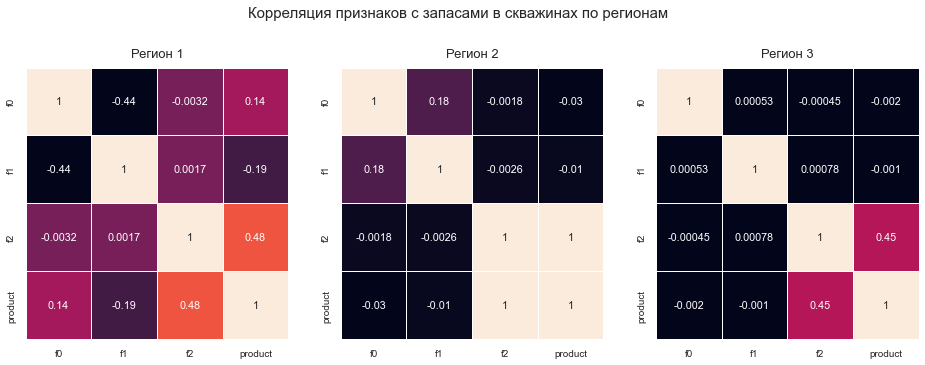

In [12]:
corr_graph, ax = plt.subplots(1,3, figsize = (16, 5))
corr_graph.suptitle('Корреляция признаков с запасами в скважинах по регионам', fontsize=15, y=1.05) 
for i, r in zip(range(3), [r1, r2, r3]):
    matrix = r.corr()
    sns.heatmap(matrix, ax=ax[i], linewidths=0.5, annot=True, cbar=False)
    ax[i].set_title('Регион ' + str(i+1), pad=10, fontsize=13)

**Регион 1**

Сильнее всего с целевой переменной (объем скважины) коррелирует признак `f2`: корреляция прямая, коэффициент равен 0,48.

Также видна сильная обратная корреляция между признаками f0 и f1 — коэффициент равен -0,44. Однако она не настолько большая, чтобы избавляться от одного из признаков или применять регуляризацию.

**Регион 2**

В этом регионе запасы скважины сильно зависят от признака f2. Коэффициент корреляции с ним равен 1 — это максимальное значение.

Между собой независимые признаки почти не коррелируют. Выдеялется пара f0 и f1, но коэффициент маленький — 0,18.

**Регион 3**

Так же, как и во втором регионе, объем запасов больше всего зависит от признака f2. Но здесь корреляция гораздо слабее, коэффициент равен 0,45.

Корреляций между независимыми признаками нет.

[К содержанию](#Содержание)

## 2. Подготовка данных<a name="2.-Подготовка-данных"></a>

### Разбиение на тренировочные и валидационные выборки<a name="Разбиение-на-тренировочные-и-валидационные-выборки"></a>

Перед обучением выделим из датафреймов целевой признак и поделим их на обучающие и валидационные выборки.

In [13]:
def split_for_training(df):
    """Функция для разбиения данных по региону на тренировочную и валидационную выборки"""
    X = df.drop(['id', 'product'], axis=1)
    y = df['product']
    
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.25, random_state=SEED)
    
    return X_train, X_val, y_train, y_val

In [14]:
def check_split(X, X_train, X_val):
    """Функция для проверки корректности разбиение данных по региону на выборки"""
    samps = pd.Series(['Полная', 'Тренировочная', 'Валидационная'])
    samps_sizes = pd.Series([len(X), len(X_train), len(X_val)])
    samps_shares = pd.Series([len(X)/len(X), len(X_train)/len(X), len(X_val)/len(X)])
    
    res = pd.concat([samps, samps_sizes, samps_shares], axis=1)
    res.columns = ['Выборка', 'Размер', 'Доля от полной']
    
    return res

#### Регион 1

In [15]:
r1_X_train, r1_X_val, r1_y_train, r1_y_val = split_for_training(r1)

In [16]:
check_split(r1, r1_X_train, r1_X_val)

,Выборка,Размер,Доля от полной
0,Полная,100000,1.00
1,Тренировочная,75000,0.75
2,Валидационная,25000,0.25


#### Регион 2

In [17]:
r2_X_train, r2_X_val, r2_y_train, r2_y_val = split_for_training(r2)

In [18]:
check_split(r2, r2_X_train, r2_X_val)

,Выборка,Размер,Доля от полной
0,Полная,100000,1.00
1,Тренировочная,75000,0.75
2,Валидационная,25000,0.25


#### Регион 3

In [19]:
r3_X_train, r3_X_val, r3_y_train, r3_y_val = split_for_training(r3)

In [20]:
check_split(r3, r3_X_train, r3_X_val)

,Выборка,Размер,Доля от полной
0,Полная,100000,1.00
1,Тренировочная,75000,0.75
2,Валидационная,25000,0.25


 Все выборки для всех регионов поделены корректно.

### Масштабирование признаков<a name="Масштабирование-признаков"></a>

При знакомстве с данными мы обнаружили, что у независимых признаков разный масштаб: они имеют сильно различающиеся средние и стандартные отклонения. Линейная регрессия плохо работает с такими данными.

Стандартизируем признаки, то есть приведем их к распредлению со средним 0 и дисперсией 1.

In [21]:
def scale_train_val(X_train, X_val):
    """
    Функция для стандартизации обучающей и валидационной выборок.
    
    Стандартизатор «учится» (рассчитывает среднее и дисперсию) на тренировочной выборке.
    Затем мы прогоняем через него и тренировочную, валидационную выборки.
    """
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
    
    return X_train_scaled, X_val_scaled

#### Регион 1

In [22]:
r1_X_train_scaled, r1_X_val_scaled = scale_train_val(r1_X_train, r1_X_val)
r1_X_train_scaled.head()

,f0,f1,f2
0,1.274786,-0.799739,-0.396677
1,-1.600689,0.234678,-2.169283
2,-0.323791,1.436297,1.495425
3,0.439038,0.830679,0.185881
4,-1.652805,0.761012,0.111734


#### Регион 2

In [23]:
r2_X_train_scaled, r2_X_val_scaled = scale_train_val(r2_X_train, r2_X_val)
r2_X_train_scaled.head()

,f0,f1,f2
0,0.911229,0.063780,-0.291331
1,1.640885,1.320793,1.463778
2,-0.303818,0.859595,0.297952
3,1.250304,-0.332629,-0.290244
4,-0.678630,-0.629111,-0.877242


#### Регион 3

In [24]:
r3_X_train_scaled, r3_X_val_scaled = scale_train_val(r3_X_train, r3_X_val)
r3_X_train_scaled.head()

,f0,f1,f2
0,-0.343864,-1.338311,0.817572
1,-0.400431,0.993613,-1.102974
2,1.004849,-0.923485,-0.576264
3,-0.784031,0.571573,0.914886
4,0.619771,0.681588,-0.429467


[К содержанию](#Содержание)

## 3. Сравнение регионов по количеству предсказанных запасов и качеству предсказаний<a name="3.-Сравнение-регионов-по-количеству-предсказанных-запасов-и-качеству-предсказаний"></a>

### Обучение моделей<a name="Обучение-моделей"></a>

In [25]:
def linreg_fit(X_train, y_train):
    """Функция возвращает модель линейной регресии, обученную на переданных в функцию данных."""
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

Создадим модели для каждого региона и обучим их на тренировочных выборках. Для обучения будем использовать линейную регрессию, так как остальные методы недостаточно предсказуемые.

Обучим модели на тренировочных выборках и сделаем предсказания на тестовых.

In [26]:
r1_model = linreg_fit(r1_X_train_scaled, r1_y_train)
r1_model

LinearRegression()

In [27]:
r2_model = linreg_fit(r2_X_train_scaled, r2_y_train)
r2_model

LinearRegression()

In [28]:
r3_model = linreg_fit(r3_X_train_scaled, r3_y_train)
r3_model

LinearRegression()

### Сравнение регионов<a name="Сравнение-регионов"></a>

Сравним регионы по среднему запасу предсказанного сырья и по качеству моделей, которые обучались на данных из регоина.

In [29]:
def region_reserve_and_model_metrics(model, X, y, title=''):
    """Функция для определения среднего запаса в скважине и расчета метрик качества предсказаний"""
    preds = model.predict(X)
    mean_reserve = preds.mean()
    rmse = mean_squared_error(y, preds, squared=False)
    
    print('\033[1m' + title + '\033[0m')
    print(f'Средний запас предсказанного сырья: {mean_reserve:.2f} тыс. баррелей')
    print(f'RMSE модели: {rmse:.2f} тыс. баррелей')
    print(f'Коэффициент детерменации модели: {r2_score(y, preds):.3f}')

In [30]:
region_reserve_and_model_metrics(r1_model, r1_X_val_scaled, r1_y_val, 'Регион 1')

Регион 1
Средний запас предсказанного сырья: 92.40 тыс. баррелей
RMSE модели: 37.76 тыс. баррелей
Коэффициент детерменации модели: 0.273


In [31]:
region_reserve_and_model_metrics(r2_model, r2_X_val_scaled, r2_y_val, 'Регион 2')

Регион 2
Средний запас предсказанного сырья: 68.71 тыс. баррелей
RMSE модели: 0.89 тыс. баррелей
Коэффициент детерменации модели: 1.000


In [32]:
region_reserve_and_model_metrics(r3_model, r3_X_val_scaled, r3_y_val, 'Регион 3')

Регион 3
Средний запас предсказанного сырья: 94.77 тыс. баррелей
RMSE модели: 40.15 тыс. баррелей
Коэффициент детерменации модели: 0.196


**Регионы 1 и 3**

В первом и третьем регионе модели сделали примерно одинаковые предсказания. Средний предсказанный объем запасов в скважинах получился большим, однако модели плохо поняли данные по регионам. Об этом говорит высокий RMSE (больше 40% от среднего предсказанного объема) и низкий коэффициент детерминации.

**Регион 2**

Второй регион сильно отличается от первого и третьего. Средний предсказанный объем запасов в нем меньше на 30%, зато предсказания точные: об этом говорят максимальный коэффициент детерминации и низкий RMSE (меньше 1).

Скорее всего, такая точность объясняется тем, что во втором регионе запасы в скважинах сильно коррелируют с признаком f2. Коэффициент корреляции равен 1, то есть объем запасов можно предсказать всего по одной переменной.

[К содержанию](#Содержание)

## 4. Расчет прибыли и рисков<a name="4.-Расчет-прибыли-и-рисков"></a>

Вспомним, как проходит разведка региона:

1. В каждом регионе собирают характеристики уже разработанных скважин и запасы в них.
2. На собранных данных обучают модели, чтобы затем с их помощью оценивать запасы в новых скважинах.
3. В регионах ищут новые скважины и оценивают их запасы. 
4. Выбирают скважины с самым высокими оценками.
5. Определяют регион с максимальной суммарной прибылью отобранных скважин.

Условия разведки:

1. При разведке региона исследуют 500 точек, из которых с помощью модели выбирают 200 лучших для разработки.
2. Бюджет на разработку скважин в регионе — 10 млрд рублей.
3. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

Первый и второй шаги из пайплайна разведки мы сделали. Теперь смоделируем 3–5.

Нам нужно оценить, какую прибыль мы можем получить в каждом регионе, если пройдем в нем весь план разведки. То есть если мы приедем в каждый регион, найдем в нем 500 скважин и разработаем 200 лучших, потратив на это 10 млрд рублей, то какую прибыль с региона после этого всего мы получим?

Чтобы ответить на этот вопрос, воспользуемся бутстрэпом: много раз проведем такой эксперимент на валидационной выборке. После всех экспериментов мы получим распределение потенциальной прибыли и сможем рассчитать его среднее (то есть среднюю потенциальную прибыль с региона) и доверительный интервал для прибыли.

Также для каждого региона будем оценивать риск убытков — вероятность получить убыток в регионе. Расчитывается как доля отрицательной доходности с региона от всех рассчитанных доходностей.

In [33]:
N_HOLES = 500
N_BEST_HOLES = 200

REGION_BUDGET = 10 * 10**9

REVENUE_PER_PRODUCT = 450 * 10**3

### Расчет прибыли от разработки региона<a name="Расчет-прибыли-от-разработки-региона"></a>

In [34]:
def explore_region(X, model, y):
    """
    Функция «симулирует» разведку региона:
    1. выбирает 500 случайных скважин;
    2. рассчитывает для них потенциальные прибыли на основе предсказаний запасов от модели;
    3. выбирает 200 лучших по предсказанию скважин;
    4. считает реальный суммарный объем в отобранных скважинах, то есть как будто разрабатывает их;
    5. расчитывает прибыль с регоина.
    """
    X_sample = X.sample(n=N_HOLES, replace=True,
                        random_state=RANDOM_STATE)
    preds = model.predict(X_sample)
    preds = pd.Series(preds, index=X_sample.index)
    
    preds_sorted = preds.sort_values(ascending=False)
    preds_best = preds_sorted[:N_BEST_HOLES]
    product_best = y[preds_best.index]
    
    revenue_sum = product_best.sum() * REVENUE_PER_PRODUCT
    profit = revenue_sum - REGION_BUDGET
    
    return profit

### Bootstrap для многократного моделирования разработки региона<a name="Bootstrap-для-многократного-моделирования-разработки-региона"></a>

In [35]:
def region_bootstrap(X, model, y):
    """
    Функция тысячу раз проводит эксперимент — разведку региона
    и возвращает распределение получившихся прибылей.
    """
    # При масштабировании признаков индексы в выборке сбросились.
    # Сбросим их у целевых переменных.
    y = y.reset_index(drop=True)
    profits = []
    
    for i in range(1000):
        profit = explore_region(X, model, y)
        profits.append(profit)
        
    profits = pd.Series(profits)
    return profits

### Доверительный интервал для прибыли<a name="Доверительный-интервал-для-прибыли"></a>

In [36]:
def confidence_interval(values, conf=0.95):
    """Функция для расчета доверительного интервала для прибыли в регионе"""
    lower = values.quantile((1-conf)/2)
    upper = values.quantile(conf + (1-conf)/2)
    return lower, upper

### Расчет риска убытков от разработки региона<a name="Расчет-риска-убытков-от-разработки-региона"></a>

In [37]:
def loss_risk(profits):
    """Функция для расчета риска получить убыток в регионе"""
    res = (profits < 0).mean()
    return res

### Сравнение регионов<a name="Сравнение-регионов"></a>

In [38]:
def print_region_profit_stats(X, model, y, title=''):
    """Функция объединяет и выводит данные по потенциальной разведке в регионе"""
    profits = region_bootstrap(X, model, y)
    mean_profit = profits.mean()
    lower, upper = confidence_interval(profits)
    risk = loss_risk(profits)
    
    print('\033[1m' + title + '\033[0m')
    print(f'Средняя потенциальная прибыль с региона: {mean_profit / 10**6 :.2f} млн рублей')
    print(f'95% доверительный интервал прибыли: от {lower / 10**6 :.2f} до {upper / 10**6 :.2f} млн рублей')
    print(f'Риск убытков: {risk:.2%}')

In [39]:
print_region_profit_stats(r1_X_val_scaled, r1_model, r1_y_val, 'Регион 1')

Регион 1
Средняя потенциальная прибыль с региона: 399.58 млн рублей
95% доверительный интервал прибыли: от -110.47 до 897.46 млн рублей
Риск убытков: 6.00%


In [40]:
print_region_profit_stats(r2_X_val_scaled, r2_model, r2_y_val, 'Регион 2')

Регион 2
Средняя потенциальная прибыль с региона: 452.58 млн рублей
95% доверительный интервал прибыли: от 52.31 до 830.15 млн рублей
Риск убытков: 0.90%


In [41]:
print_region_profit_stats(r3_X_val_scaled, r3_model, r3_y_val, 'Регион 3')

Регион 3
Средняя потенциальная прибыль с региона: 378.71 млн рублей
95% доверительный интервал прибыли: от -127.78 до 907.92 млн рублей
Риск убытков: 7.50%


По итогам анализа самый привлекательный для разработки регион — второй. В нем самая большая средняя потенциальная прибыль и наименьший риск убытков. Также в его 95% доверительный интервал не входят отрицательные значения. Значит, с вероятностью 95% разработка новых скважин в регионе не будет убыточна.

[К содержанию](#Содержание)